In [1]:
!pip install xgboost joblib


In [2]:
import os, json, math, re, gc, random, warnings, joblib
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
random.seed(42); np.random.seed(42)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# === EDIT ROOT if your Drive path differs ===
ROOT = "/content/drive/MyDrive/MUFG SIH"

# Your labeled MFCC table (produced earlier)
MFCC_CSV_IN  = f"{ROOT}/processed/audio_features_merged_with_labels.csv"

# Outputs
OUT_PROC_DIR = f"{ROOT}/processed/audio"
OUT_ADV_DIR  = f"{ROOT}/processed/adv/audio"
OUT_MODELS   = f"{ROOT}/models_audio"
OUT_LOGS     = f"{ROOT}/logs/eval"

os.makedirs(OUT_PROC_DIR, exist_ok=True)
os.makedirs(OUT_ADV_DIR,  exist_ok=True)
os.makedirs(OUT_MODELS,   exist_ok=True)
os.makedirs(OUT_LOGS,     exist_ok=True)

MEMORY_JSON = f"{OUT_PROC_DIR}/audio_antibody_memory.json"
PRED_CSV    = f"{OUT_PROC_DIR}/audio_agentic_calibrated.csv"
ADV_BUF_CSV = f"{OUT_ADV_DIR}/audio_adv_buffer.csv"
EVAL_JSON   = f"{OUT_LOGS}/audio_cycle_eval.json"

# Thresholding & loop params
TARGET_FPR       = 0.01     # 1%
BORDER_EPS       = 0.05     # ±5% band around threshold for "adaptive" escalation
QUARANTINE_FLOOR = 0.80     # auto-quarantine if prob >= max(threshold, 0.80)
ADV_K_PER_SAMPLE = 3        # red variants per borderline/slipped sample
ADV_MAX_PER_TAG  = 500      # cap per weakness tag in retrain


Mounted at /content/drive


In [4]:
# === Load MFCC table & build features (with -1 filtering) ===
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def find_mfcc_columns(columns):
    mfcc_cols = [c for c in columns if re.match(r"(?i)^mfcc[_\- ]?\d+$", str(c))]
    if not mfcc_cols:
        mfcc_cols = [c for c in columns if str(c).lower().startswith("mfcc")]
    return mfcc_cols

# Load
df = pd.read_csv(MFCC_CSV_IN) if MFCC_CSV_IN.lower().endswith(".csv") else pd.read_excel(MFCC_CSV_IN)

# Must have label
assert "label" in df.columns, "Expected a 'label' column in the MFCC CSV."

# Filter out invalid/unmatched labels (-1)
print("[INFO] Before drop (rows, cols):", df.shape)
n_neg1 = int((df["label"] == -1).sum())
if n_neg1 > 0:
    print(f"[WARN] Dropping {n_neg1} rows with label == -1 (unmatched).")
df = df[df["label"] >= 0].reset_index(drop=True)
print("[INFO] After drop (rows, cols):", df.shape)

# Detect MFCC columns
mfcc_cols = find_mfcc_columns(df.columns)
assert len(mfcc_cols) >= 10, f"Not enough MFCC columns found. Got: {mfcc_cols}"

# Drop rows with missing MFCCs/labels
df = df.dropna(subset=mfcc_cols + ["label"]).reset_index(drop=True)

# y, X
y = df["label"].astype(int)
X = df[mfcc_cols].astype(float)

# Sanity: ensure binary labels remain
classes = np.sort(y.unique())
assert set(classes).issubset({0,1}) and len(classes) == 2, f"Need binary labels {0,1}; got {classes}. Check your data/merge."

# Optional: add simple stats (helps tabular learners)
X_feat = X.copy()
X_feat["mfcc_mean"] = X.mean(axis=1)
X_feat["mfcc_std"]  = X.std(axis=1)
X_feat["mfcc_max"]  = X.max(axis=1)
X_feat["mfcc_min"]  = X.min(axis=1)
X_feat["mfcc_rng"]  = X_feat["mfcc_max"] - X_feat["mfcc_min"]

# Splits (stratified) with fallback if extremely imbalanced
try:
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_feat, y, test_size=0.30, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
    )
except ValueError as e:
    # Fallback without stratify if a class is too tiny after filtering
    print(f"[WARN] Stratified split failed ({e}). Falling back to non-stratified split.")
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_feat, y, test_size=0.30, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=42
    )

print("Shapes:", X_train.shape, X_val.shape, X_test.shape,
      "| Class balance (train):", y_train.value_counts(normalize=True).to_dict())


[INFO] Before drop (rows, cols): (343161, 37)
[WARN] Dropping 13268 rows with label == -1 (unmatched).
[INFO] After drop (rows, cols): (329893, 37)
Shapes: (230925, 18) (49484, 18) (49484, 18) | Class balance (train): {1: 0.5009158817797986, 0: 0.4990841182202014}


In [5]:
def heuristic_risk(batch_df):
    """
    Risk in [0,1] from cheap MFCC stats:
     - very low std -> suspicious
     - low dynamic range -> suspicious
     - very high |mean| -> odd spectral envelope
    """
    eps = 1e-9
    std = batch_df["mfcc_std"].values
    rng = batch_df["mfcc_rng"].values
    mean_abs = batch_df["mfcc_mean"].abs().values

    def norm01(v):
        v = v.astype(float)
        lo, hi = np.percentile(v, 1), np.percentile(v, 99)
        return np.clip((v - lo) / max(hi - lo, eps), 0, 1)

    low_std   = 1.0 - norm01(std)
    low_rng   = 1.0 - norm01(rng)
    high_mean = norm01(mean_abs)

    risk = 0.45*low_std + 0.35*low_rng + 0.20*high_mean
    return np.clip(risk, 0, 1)

def load_memory(path):
    if os.path.exists(path):
        try:
            return json.load(open(path, "r"))
        except Exception:
            return {"low_std_hits":0, "low_rng_hits":0, "high_mean_hits":0}
    return {"low_std_hits":0, "low_rng_hits":0, "high_mean_hits":0}

def save_memory(mem, path):
    with open(path, "w") as f:
        json.dump(mem, f, indent=2)

MEM = load_memory(MEMORY_JSON)

def apply_memory_boost(risk_vec):
    # small multiplicative boost based on past hits
    scale = 1 + 0.02 * math.log1p(MEM.get("low_std_hits",0) + MEM.get("low_rng_hits",0) + MEM.get("high_mean_hits",0))
    return np.clip(risk_vec * scale, 0, 1)


In [6]:
# Fast model: XGBoost on tabular MFCCs
fast_model = XGBClassifier(
    n_estimators=400, max_depth=6, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    tree_method="hist", random_state=42, n_jobs=-1
)

# Adaptive model: MLP on same features (with scaling)
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64), activation="relu",
    solver="adam", alpha=1e-4, max_iter=30, early_stopping=True,
    random_state=42
)
adaptive_model = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", mlp)
])

fast_model.fit(X_train, y_train)
adaptive_model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(early_stopping=True,
                               hidden_layer_sizes=(128, 64), max_iter=30,
                               random_state=42))])

In [7]:
def find_threshold_at_fpr(y_true, y_prob, target_fpr=0.01):
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    ok = np.where(fpr <= target_fpr)[0]
    if len(ok) == 0:
        return thr[np.argmin(fpr)]
    best = ok[np.argmax(tpr[ok])]
    return thr[best]

def prob_fast(Xb):     return fast_model.predict_proba(Xb)[:,1]
def prob_adaptive(Xb): return adaptive_model.predict_proba(Xb)[:,1]

p_fast_val = prob_fast(X_val)
T_base = find_threshold_at_fpr(y_val, p_fast_val, TARGET_FPR)
T_low, T_high = max(0.0, T_base - BORDER_EPS), min(1.0, T_base + BORDER_EPS)
T_quarantine = max(QUARANTINE_FLOOR, T_base)

print(f"Calibrated T (FPR≤{TARGET_FPR*100:.0f}%): {T_base:.3f} | Band: [{T_low:.3f}, {T_high:.3f}] | Quarantine≥{T_quarantine:.3f}")


Calibrated T (FPR≤1%): 0.610 | Band: [0.560, 0.660] | Quarantine≥0.800


In [8]:
def orchestrate(Xb):
    # Derive stats view (works for any DF with mfcc cols or stats precomputed)
    stats_df = pd.DataFrame({
        "mfcc_mean": Xb[[c for c in Xb.columns if c in mfcc_cols]].mean(axis=1).values if set(mfcc_cols).issubset(Xb.columns) else Xb["mfcc_mean"].values,
        "mfcc_std":  Xb[[c for c in Xb.columns if c in mfcc_cols]].std(axis=1).values  if set(mfcc_cols).issubset(Xb.columns) else Xb["mfcc_std"].values,
        "mfcc_rng":  (Xb[[c for c in Xb.columns if c in mfcc_cols]].max(axis=1) -
                      Xb[[c for c in Xb.columns if c in mfcc_cols]].min(axis=1)).values if set(mfcc_cols).issubset(Xb.columns) else Xb["mfcc_rng"].values
    })

    h = apply_memory_boost(heuristic_risk(stats_df))
    p1 = prob_fast(Xb)
    p  = 0.30*h + 0.70*p1

    stage = np.where((p >= T_low) & (p <= T_high), "adaptive", "innate")

    idx_adapt = np.where(stage == "adaptive")[0]
    p_final = p.copy()
    if len(idx_adapt) > 0:
        pa = prob_adaptive(Xb.iloc[idx_adapt])
        p_final[idx_adapt] = 0.50*p[idx_adapt] + 0.50*pa

    pred = (p_final >= T_base).astype(int)
    return stage, p_final, pred, h, p1


In [9]:
def evaluate_split(name, Xb, yb):
    stage, p, pred, h, p1 = orchestrate(Xb)
    auc = roc_auc_score(yb, p)
    cm  = confusion_matrix(yb, pred)
    rep = classification_report(yb, pred, digits=3)
    print(f"\n[{name}] AUC={auc:.4f} @T={T_base:.3f}\n{rep}")
    out = {"name": name, "auc": float(auc), "threshold": float(T_base),
           "fpr_target": TARGET_FPR, "confusion_matrix": cm.tolist(), "report": rep}
    return out, (stage, p, pred, h, p1)

eval_val,  val_tuple  = evaluate_split("VAL",  X_val,  y_val)
eval_test, test_tuple = evaluate_split("TEST", X_test, y_test)



[VAL] AUC=0.4346 @T=0.610
              precision    recall  f1-score   support

           0      0.497     0.993     0.663     24696
           1      0.100     0.001     0.002     24788

    accuracy                          0.496     49484
   macro avg      0.299     0.497     0.332     49484
weighted avg      0.298     0.496     0.332     49484


[TEST] AUC=0.4358 @T=0.610
              precision    recall  f1-score   support

           0      0.497     0.993     0.663     24697
           1      0.064     0.000     0.001     24787

    accuracy                          0.496     49484
   macro avg      0.281     0.497     0.332     49484
weighted avg      0.280     0.496     0.331     49484



In [10]:
stage_val, p_val, pred_val, h_val, p1_val = val_tuple
quarantine_idx = np.where(p_val >= T_quarantine)[0]

# Update memory counts using quantiles
MEM["low_std_hits"]   += int(((X_val["mfcc_std"].iloc[quarantine_idx]) < X_val["mfcc_std"].quantile(0.1)).sum())
MEM["low_rng_hits"]   += int(((X_val["mfcc_rng"].iloc[quarantine_idx]) < X_val["mfcc_rng"].quantile(0.1)).sum())
MEM["high_mean_hits"] += int(((X_val["mfcc_mean"].iloc[quarantine_idx]).abs() > X_val["mfcc_mean"].abs().quantile(0.9)).sum())
save_memory(MEM, MEMORY_JSON)

print(f"Quarantined {len(quarantine_idx)} high-risk VAL samples. Memory updated → {MEM}")


Quarantined 1 high-risk VAL samples. Memory updated → {'low_std_hits': 2, 'low_rng_hits': 2, 'high_mean_hits': 2}


In [11]:
def weakness_tags(Xb):
    std = Xb["mfcc_std"].values
    rng = Xb["mfcc_rng"].values
    mean_abs = Xb["mfcc_mean"].abs().values
    tags = []
    for s, r, m in zip(std, rng, mean_abs):
        tag = []
        if s < np.quantile(std, 0.2): tag.append("low_std")
        if r < np.quantile(rng, 0.2): tag.append("low_rng")
        if m > np.quantile(mean_abs, 0.8): tag.append("high_mean")
        if not tag: tag = ["generic"]
        tags.append("+".join(tag))
    return tags

def red_generate_variants(row, k=3, seed=42):
    """
    MFCC-space perturbations approximating channel effects:
     - add small noise to higher-order MFCCs
     - light scale + bias, then clamp to train dist
    """
    rng = np.random.default_rng(seed + hash(tuple(row.values))%1_000_000)
    base = row.copy()
    variants = []
    mf = base[mfcc_cols].values.astype(float)
    global_mu = X_train[mfcc_cols].mean().values
    global_sd = X_train[mfcc_cols].std().values + 1e-6

    for _ in range(k):
        v = mf.copy()
        idx = list(range(min(5, len(v)), len(v)))  # tweak higher-order MFCCs more
        if idx:
            v[idx] += rng.normal(0, 0.15, size=len(idx))
        scale = rng.uniform(0.95, 1.05)
        bias  = rng.normal(0, 0.05)
        v = v*scale + bias
        v = np.clip(v, global_mu - 3*global_sd, global_mu + 3*global_sd)
        new_row = base.copy()
        for c, val in zip(mfcc_cols, v):
            new_row[c] = val
        variants.append(new_row)
    return variants

border_idx  = np.where((p_val >= T_low) & (p_val <= T_high))[0]
slipped_idx = np.where((y_val.values != (p_val>=T_base).astype(int)))[0]
cand_idx = np.unique(np.concatenate([border_idx, slipped_idx]))[:2000]

adv_rows = []
kept = 0
tags_all = weakness_tags(X_val.iloc[cand_idx])

for idx,i in enumerate(cand_idx):
    row = X_val.iloc[i]
    base_prob_before = float(p_val[i])
    tag = tags_all[idx]

    variants = red_generate_variants(row, k=ADV_K_PER_SAMPLE, seed=42+i)
    for vrow in variants:
        vdf = pd.DataFrame([vrow])
        _, pv, pv_pred, _, _ = orchestrate(vdf)
        prob_after = float(pv[0])
        margin_before = abs(base_prob_before - T_base)
        margin_after  = abs(prob_after - T_base)
        flipped = int(((base_prob_before>=T_base) != (prob_after>=T_base)))
        tighter = int(margin_after < margin_before)

        if flipped or tighter:
            adv_rows.append({
                "parent_idx": int(i),
                "gen_method": "mfcc_delta",
                "weakness_tag": tag,
                "prob_before": base_prob_before,
                "prob_after": prob_after,
                "flipped": flipped,
                "tighter_margin": tighter
            })
            kept += 1

adv_df = pd.DataFrame(adv_rows)
if len(adv_df):
    if os.path.exists(ADV_BUF_CSV):
        adv_df.to_csv(ADV_BUF_CSV, mode="a", header=False, index=False)
    else:
        adv_df.to_csv(ADV_BUF_CSV, index=False)

print(f"Red generated {len(cand_idx)*ADV_K_PER_SAMPLE} variants; kept {kept} adversarials → {ADV_BUF_CSV}")


Red generated 6000 variants; kept 5075 adversarials → /content/drive/MyDrive/MUFG SIH/processed/adv/audio/audio_adv_buffer.csv


In [12]:
def sample_adv_rows(adv_csv, max_per_tag=ADV_MAX_PER_TAG):
    if not os.path.exists(adv_csv):
        return pd.DataFrame(columns=["parent_idx","gen_method","weakness_tag","prob_before","prob_after","flipped","tighter_margin"])
    df_adv = pd.read_csv(adv_csv)
    if "weakness_tag" not in df_adv.columns or len(df_adv)==0:
        return df_adv
    parts = []
    for tag, grp in df_adv.groupby("weakness_tag"):
        parts.append(grp.sample(n=min(max_per_tag, len(grp)), random_state=42))
    return pd.concat(parts, axis=0).reset_index(drop=True)

adv_buf = sample_adv_rows(ADV_BUF_CSV, ADV_MAX_PER_TAG)

if len(adv_buf):
    parent_indices = adv_buf["parent_idx"].astype(int).values
    X_adv = X_val.iloc[parent_indices].copy()
    y_adv = y_val.iloc[parent_indices].copy()

    X_train_adv = pd.concat([X_train, X_adv], axis=0).reset_index(drop=True)
    y_train_adv = pd.concat([y_train, y_adv], axis=0).reset_index(drop=True)

    fast_model.fit(X_train_adv, y_train_adv)
    adaptive_model.fit(X_train_adv, y_train_adv)

    eval_val_adv,  _  = evaluate_split("VAL_retrained",  X_val,  y_val)
    eval_test_adv, tt = evaluate_split("TEST_retrained", X_test, y_test)
else:
    print("No adversarial buffer yet; skipping retrain.")
    eval_val_adv,  eval_test_adv = eval_val, eval_test
    tt = test_tuple



[VAL_retrained] AUC=0.4399 @T=0.610
              precision    recall  f1-score   support

           0      0.497     0.992     0.663     24696
           1      0.111     0.001     0.002     24788

    accuracy                          0.496     49484
   macro avg      0.304     0.497     0.332     49484
weighted avg      0.304     0.496     0.332     49484


[TEST_retrained] AUC=0.4370 @T=0.610
              precision    recall  f1-score   support

           0      0.497     0.992     0.663     24697
           1      0.074     0.001     0.001     24787

    accuracy                          0.496     49484
   macro avg      0.286     0.496     0.332     49484
weighted avg      0.285     0.496     0.331     49484



In [13]:
stage_t, p_t, pred_t, h_t, p1_t = tt
out_pred = pd.DataFrame({
    "id": np.arange(len(X_test)),
    "pred": pred_t,
    "spoof_prob": p_t,
    "stage": stage_t,
    "heuristic": h_t,
    "fast_score": p1_t
})
out_pred.to_csv(PRED_CSV, index=False)

joblib.dump(fast_model,     f"{OUT_MODELS}/audio_fast_xgb.joblib")
joblib.dump(adaptive_model, f"{OUT_MODELS}/audio_adaptive_mlp.joblib")

EVAL = {
    "val_before": eval_val, "test_before": eval_test,
    "val_after":  eval_val_adv, "test_after": eval_test_adv,
    "threshold": float(T_base), "band":[float(T_low), float(T_high)],
    "quarantine_floor": float(T_quarantine),
    "memory": MEM,
    "timestamps": {"saved_at": datetime.utcnow().isoformat()+"Z"}
}
json.dump(EVAL, open(EVAL_JSON,"w"), indent=2)

print(f"\nSaved:\n- Predictions → {PRED_CSV}\n- Models → {OUT_MODELS}\n- Adv buffer → {ADV_BUF_CSV}\n- Eval JSON → {EVAL_JSON}")



Saved:
- Predictions → /content/drive/MyDrive/MUFG SIH/processed/audio/audio_agentic_calibrated.csv
- Models → /content/drive/MyDrive/MUFG SIH/models_audio
- Adv buffer → /content/drive/MyDrive/MUFG SIH/processed/adv/audio/audio_adv_buffer.csv
- Eval JSON → /content/drive/MyDrive/MUFG SIH/logs/eval/audio_cycle_eval.json


In [14]:
N = len(X_test)
innate_wh = 0.01   # placeholder energy per item for fast path
adapt_wh  = 0.08   # placeholder extra energy for adaptive path
adaptive_rate = (stage_t=="adaptive").mean()
energy_agentic  = (1-adaptive_rate)*innate_wh*N + adaptive_rate*(innate_wh+adapt_wh)*N
energy_all_heavy= (innate_wh+adapt_wh)*N
co2_factor = 0.45/1000  # kg per Wh (illustrative)
print(f"Green-IT: agentic ≈ {energy_agentic:.2f} Wh vs all-heavy ≈ {energy_all_heavy:.2f} Wh | CO2 saved ≈ {(energy_all_heavy-energy_agentic)*co2_factor:.4f} kg")


Green-IT: agentic ≈ 1696.04 Wh vs all-heavy ≈ 4453.56 Wh | CO2 saved ≈ 1.2409 kg


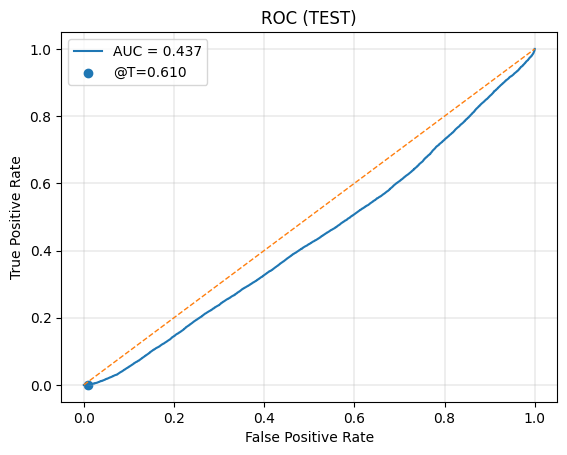

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Use final probabilities on TEST (from orchestrate earlier)
_, p_test, pred_test, _, _ = orchestrate(X_test)
auc = roc_auc_score(y_test, p_test)

fpr, tpr, thr = roc_curve(y_test, p_test)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
# mark operating threshold
idx = np.argmin(np.abs(thr - T_base))
plt.scatter([fpr[idx]], [tpr[idx]], marker='o', label=f"@T={T_base:.3f}")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (TEST)")
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()


=== Class Metrics (TEST @ Threshold) ===
Real (0):  Precision=0.497  Recall=0.992  F1=0.663  Support=24697
Fake (1):  Precision=0.074  Recall=0.001  F1=0.001  Support=24787
Overall accuracy: 0.496


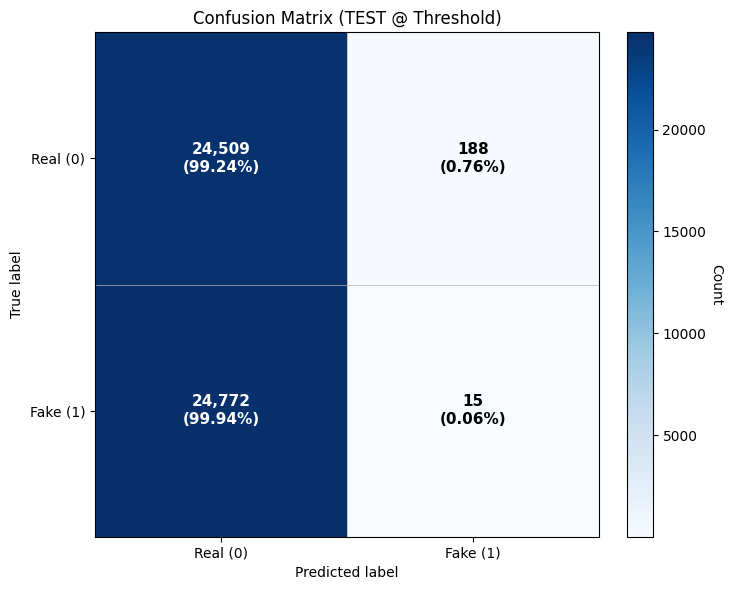

In [22]:
# Pretty Confusion Matrix (TEST) — counts + row % with nicer colormap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# ---- inputs assumed available: y_test, p_test, T_base ----
y_pred = (p_test >= T_base).astype(int)
cm = confusion_matrix(y_test, y_pred, labels=[0,1]).astype(float)

# Row-normalized percentages
row_sums = cm.sum(axis=1, keepdims=True)
cm_pct = np.divide(cm, np.maximum(row_sums, 1), where=row_sums>0)

# Optional: print class metrics above the plot
prec, rec, f1, sup = precision_recall_fscore_support(y_test, y_pred, labels=[0,1], zero_division=0)
print("=== Class Metrics (TEST @ Threshold) ===")
print(f"Real (0):  Precision={prec[0]:.3f}  Recall={rec[0]:.3f}  F1={f1[0]:.3f}  Support={sup[0]}")
print(f"Fake (1):  Precision={prec[1]:.3f}  Recall={rec[1]:.3f}  F1={f1[1]:.3f}  Support={sup[1]}")
print(f"Overall accuracy: {(y_test==y_pred).mean():.3f}")

# ------- Plot -------
fig, ax = plt.subplots(figsize=(8, 6))
cmap = plt.cm.Blues  # cleaner palette; try plt.cm.Greens or plt.cm.Oranges
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

ax.set_title("Confusion Matrix (TEST @ Threshold)")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Real (0)", "Fake (1)"])
ax.set_yticklabels(["Real (0)", "Fake (1)"])
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")

# Grid for readability
ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

# Annotate each cell: count + row-percent
for i in range(2):
    for j in range(2):
        count = int(cm[i, j])
        pct   = cm_pct[i, j] * 100.0
        # choose text color based on background intensity
        color = "white" if cm[i, j] > cm.max() * 0.6 else "black"
        ax.text(j, i, f"{count:,}\n({pct:.2f}%)",
                ha="center", va="center", color=color, fontsize=11, fontweight="bold")

# Colorbar (count scale)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Count", rotation=270, labelpad=12)

plt.tight_layout()
plt.show()


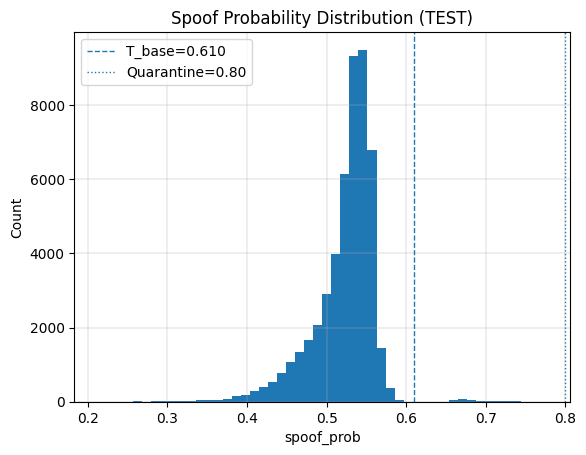

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.hist(p_test, bins=50)
plt.axvline(T_base, linestyle='--', linewidth=1, label=f"T_base={T_base:.3f}")
plt.axvline(T_quarantine, linestyle=':', linewidth=1, label=f"Quarantine={T_quarantine:.2f}")
plt.title("Spoof Probability Distribution (TEST)")
plt.xlabel("spoof_prob")
plt.ylabel("Count")
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()


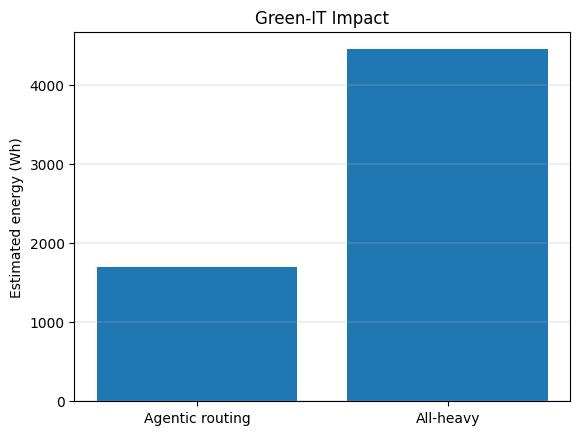

In [20]:
import matplotlib.pyplot as plt

# reuse quick estimate from notebook
N = len(X_test)
innate_wh = 0.01
adapt_wh  = 0.08
adaptive_rate = (stage_t=="adaptive").mean()
agentic  = (1-adaptive_rate)*innate_wh*N + adaptive_rate*(innate_wh+adapt_wh)*N
allheavy = (innate_wh+adapt_wh)*N

plt.figure()
plt.bar(["Agentic routing","All-heavy"], [agentic, allheavy])
plt.ylabel("Estimated energy (Wh)")
plt.title("Green-IT Impact")
plt.grid(True, axis='y', linewidth=0.3)
plt.show()
